In [ ]:
!pip install piml

# Data Pipeline

In [3]:
from piml import Experiment
exp = Experiment()
exp.data_loader(data='SimuCredit')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Mortgage  Balance  Amount Past Due  Credit Inquiry  Open Trade  \
0      196153.90  2115.19             0.00             0.0         0.0   
1      149717.49  2713.77          1460.57             1.0         1.0   
2      292626.34  2209.01             0.00             0.0         0.0   
3      264812.52    21.68             0.00             0.0         0.0   
4      236374.39  1421.49          1290.85             0.0         0.0   
...          ...      ...              ...             ...         ...   
19995  236123.54  3572.34             0.00             0.0         0.0   
19996  374572.72  3560.24             0.00             0.0         0.0   
19997  279238.55   101.75             0.00             0.0         0.0   
19998  149678.27   439.46           214.36             1.0         0.0   
19999  265153.92   909.82             0.00             0.0         0.0   

       Delinquency  Utilization  Gender  Race  Approved  
0              0.0     0.759069     1.0   0.0       1.0  
1              1.0     0.402820     1.0   0.0       1.0  
2              0.0     0.684272     1.0   1.0       1.0  
3              0.0     0.037982     0.0   0.0       0.0  
4              2.0     0.231110     1.0   1.0       1.0  
...            ...          ...     ...   ...       ...  
19995          0.0     0.896326     1.0   1.0       0.0  
19996          0.0     0.648893     1.0   1.0       0.0  
19997          0.0     0.068079     0.0   1.0       0.0  
19998          2.0     0.311219     0.0   0.0       1.0  
19999          0.0     0.300862     1.0   1.0       1.0  

[20000 rows x 10 columns]

In [4]:
# Exclude ['Gender', 'Race']
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

In [5]:
exp.data_prepare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [6]:
exp.eda()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

# Model Pipeline

In [ ]:
from xgboost import XGBClassifier
exp.model_train(model=XGBClassifier(max_depth=5, n_estimators=500),
                name='XGB5')

In [10]:
from sklearn.neural_network import MLPClassifier
exp.model_train(model=MLPClassifier(hidden_layer_sizes=[20]*2,
                                    activation="relu", random_state=0),
                name='ReLUDNN')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

# Model Diagnostics

## Reliability Testing

- Quantify prediction uncertainty by probability calibration (w/o coverage guarantee)
- Feature identification in relation to prediction uncerntainty
- Unreliable region detection by slicing the quantified bandwidth


In [13]:
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [32]:
res = exp.model_diagnose(model="ReLUDNN", show="reliability_table",
                         bins=10, return_data=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Original  Calibrated
0  0.196834    0.198325

## Feature Identification

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

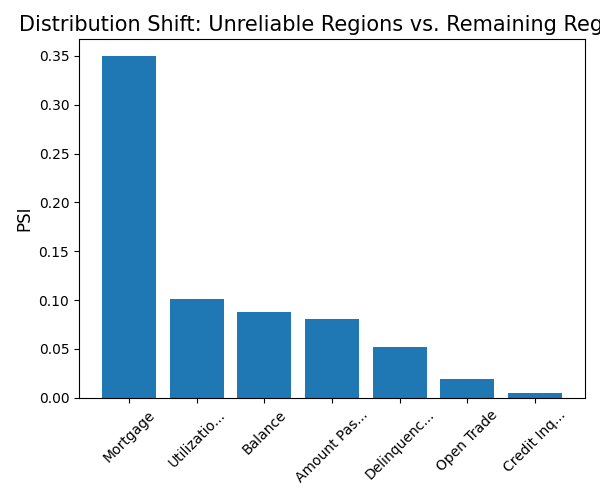

In [47]:
# Measuring distribution shift between unreliable and reliable samples
exp.model_diagnose(model="ReLUDNN",
                   show="reliability_distance",
                   threshold=1.1, distance_metric="PSI",
                   figsize=(6,5))

In [37]:
# Surrogate modeling for feature identification in relation to prediction uncertainty
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from piml.diagnoser.reliability import Reliability
from piml.explainer import PFI

def PredUQ_SurrogatePFI(model_name, alpha=0.1, max_depth=1, max_trees=200):

  # Fit reliability diagnoser
  data_dict = {'x': exp.get_data()[0],
              'y': exp.get_data()[1],
              'train_idx': exp.get_model(model_name).dataset.train_idx,
              'test_idx': exp.get_model(model_name).dataset.test_idx,
              'feature_names': exp.get_feature_names(),
              'feature_types': exp.get_feature_types()}
  reliability = Reliability(estimator=exp.get_model(model_name).estimator,
                            alpha=alpha, random_state=0)
  reliability.fit(**data_dict)

  # Fit surrogate model on bandwidth
  surrogate_model = HistGradientBoostingRegressor(max_depth=max_depth,
                                               max_iter=max_trees)
  surrogate_x = reliability.test_x
  bandwidth = reliability.method.width.reshape(-1,1)
  surrogate_model.fit(surrogate_x, bandwidth)

  # Get PFI of surrogate model
  pfi = PFI(surrogate_model, feature_names=data_dict['feature_names'])
  pfi.fit(surrogate_x, bandwidth)
  res = pfi.fi().value

  # Plot PFI bar plot
  plt.figure(figsize=(6,5))
  plt.barh(res['feature_names'], res['importance'])
  plt.xlabel("PFI")
  plt.tight_layout()
  plt.show()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

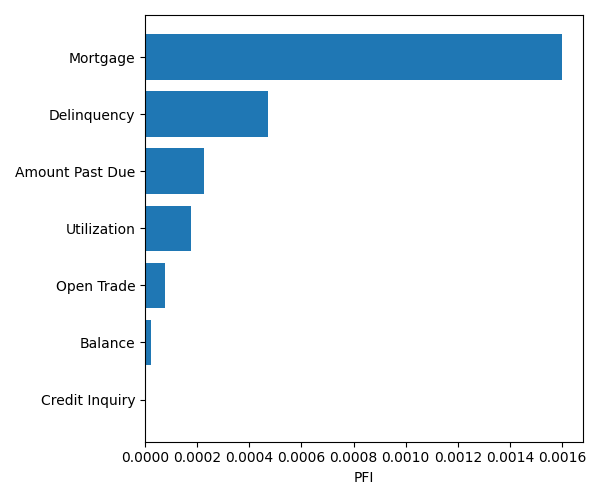

In [38]:
PredUQ_SurrogatePFI(model_name="ReLUDNN", max_depth=1, max_trees=200)

## Unreliable Region Detection

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

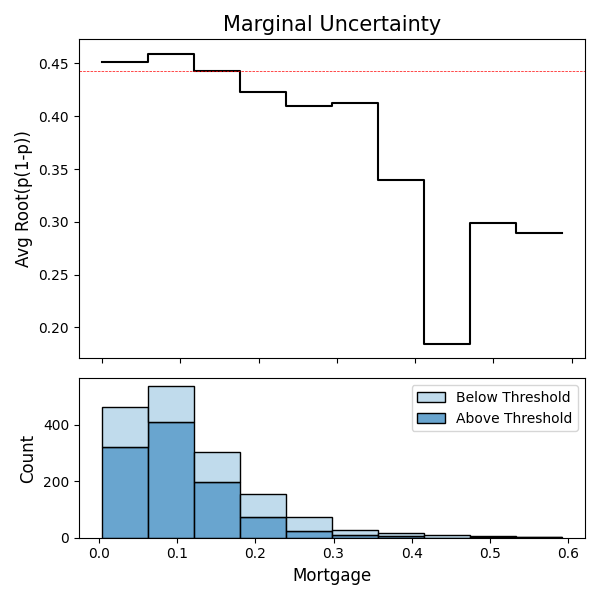

In [42]:
# Detect uncertain region
exp.model_diagnose(model="ReLUDNN", show="reliability_marginal",
                   target_feature="Mortgage",
                   threshold=1.0, bins = 10, figsize=(6,6))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

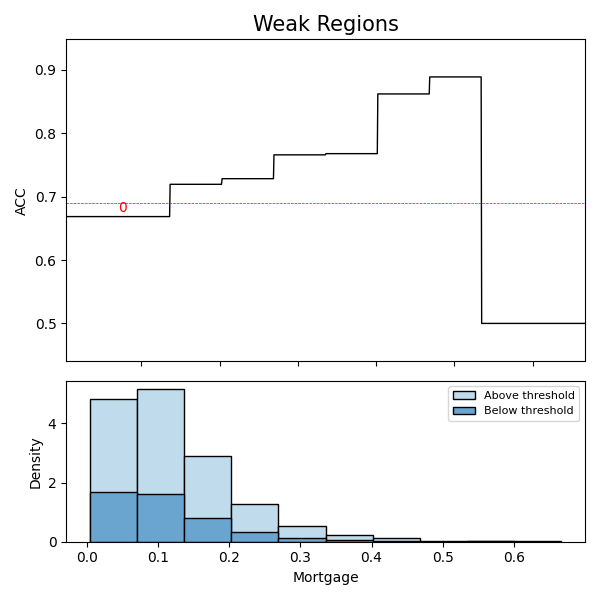

In [46]:
exp.model_diagnose(model="ReLUDNN", show="weakspot", metric="ACC",
          slice_method="histogram", slice_features=["Mortgage"],
          threshold=1.0, min_samples=20, use_test=True, figsize=(6,6))

# Prediction UQ Benchmarking

In [11]:
# SimuCredit (Binary Classification Case)
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

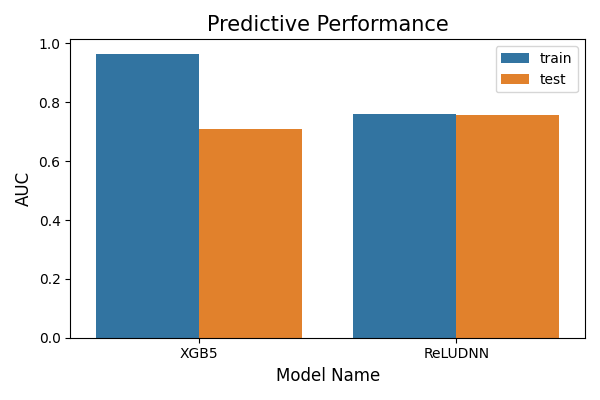

In [ ]:
exp.model_compare(models=["XGB5", "ReLUDNN"], show="accuracy_plot", metric="AUC", figsize=(6, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

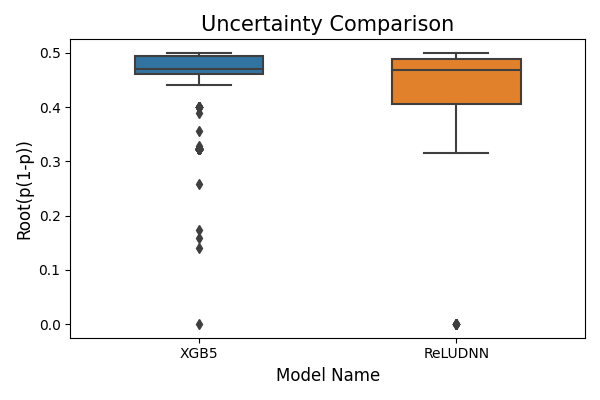

In [12]:
exp.model_compare(models=["XGB5", "ReLUDNN"],
                  show="reliability_bandwidth", figsize=(6, 4))

# Bias and Fairness

In [39]:
exp.model_fairness()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>